In [1]:
# Load the CoNLL-2003 dataset
from datasets import load_dataset

dataset = load_dataset("conll2003")

In [2]:
# Seperate the training testing and validation datasets

train_data = dataset['train']
test_data = dataset['test']
val_data = dataset['validation']
dataset['train']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

In [3]:
# Print an example
train_data[0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In our problem statement we only need whether the entity is named or not, i.e. we'll be using binary labels.

In [4]:
# Replace all NER labels by 1 and let the rest remain 0
def modify_ner_tags(example):
    example['ner_tags'] = [1 if tag > 0 else 0 for tag in example['ner_tags']]
    return example

train_data = train_data.map(modify_ner_tags) # Modify data labels as per above function
val_data = val_data.map(modify_ner_tags)
test_data = test_data.map(modify_ner_tags)

In [5]:
# print example
train_data[0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [1, 0, 1, 0, 0, 0, 1, 0, 0]}

In [6]:
all_pos_tags = {'"': 0, "''": 1, '#': 2, '$': 3, '(': 4, ')': 5, ',': 6, '.': 7, ':': 8, '``': 9, 'CC': 10, 'CD': 11, 'DT': 12,
 'EX': 13, 'FW': 14, 'IN': 15, 'JJ': 16, 'JJR': 17, 'JJS': 18, 'LS': 19, 'MD': 20, 'NN': 21, 'NNP': 22, 'NNPS': 23,
 'NNS': 24, 'NN|SYM': 25, 'PDT': 26, 'POS': 27, 'PRP': 28, 'PRP$': 29, 'RB': 30, 'RBR': 31, 'RBS': 32, 'RP': 33,
 'SYM': 34, 'TO': 35, 'UH': 36, 'VB': 37, 'VBD': 38, 'VBG': 39, 'VBN': 40, 'VBP': 41, 'VBZ': 42, 'WDT': 43,
 'WP': 44, 'WP$': 45, 'WRB': 46}

In [7]:
reverse_pos_tags = {value: key for key, value in all_pos_tags.items()}
print(reverse_pos_tags)

for key, value in reverse_pos_tags.items():
  print(f"{type(key)}")
  print(f"{type(value)}")
  break

{0: '"', 1: "''", 2: '#', 3: '$', 4: '(', 5: ')', 6: ',', 7: '.', 8: ':', 9: '``', 10: 'CC', 11: 'CD', 12: 'DT', 13: 'EX', 14: 'FW', 15: 'IN', 16: 'JJ', 17: 'JJR', 18: 'JJS', 19: 'LS', 20: 'MD', 21: 'NN', 22: 'NNP', 23: 'NNPS', 24: 'NNS', 25: 'NN|SYM', 26: 'PDT', 27: 'POS', 28: 'PRP', 29: 'PRP$', 30: 'RB', 31: 'RBR', 32: 'RBS', 33: 'RP', 34: 'SYM', 35: 'TO', 36: 'UH', 37: 'VB', 38: 'VBD', 39: 'VBG', 40: 'VBN', 41: 'VBP', 42: 'VBZ', 43: 'WDT', 44: 'WP', 45: 'WP$', 46: 'WRB'}
<class 'int'>
<class 'str'>


In [34]:
def word2features(sent, i):
    word = sent['tokens'][i]
    pos_tag = sent['pos_tags'][i]

    features = {
        'word.lower()': word.lower(),
        'is_upper': word.isupper(),
        'is_title': word.istitle(),
        'is_digit': word.isdigit(),
        'prefix-1': word[:1],
        'suffix-1': word[-1:],
        'prefix-2': word[:2],
        'suffix-2': word[-2:]
    }

    # Add current word's POS tag features
    for tag, num in all_pos_tags.items():
        features[f'pos_tag_{tag}'] = 1 if pos_tag == num else 0

    # Add previous word's features if not at the start of the sentence
    if i > 0:
        prev_word = sent['tokens'][i - 1]
        prev_pos_tag = sent['pos_tags'][i - 1]
        
        features.update({
            'prev_word.lower()': prev_word.lower(),
            'prev_is_upper': prev_word.isupper(),
            'prev_is_title': prev_word.istitle(),
            'prev_is_digit': prev_word.isdigit(),
            'prev_prefix-1': prev_word[:1],
            'prev_suffix-1': prev_word[-1:],
            'prev_prefix-2': prev_word[:2],
            'prev_suffix-2': prev_word[-2:]
        })
        
        for tag, num in all_pos_tags.items():
            features[f'prev_pos_tag_{tag}'] = 1 if prev_pos_tag == num else 0
    else:
        # Special tokens for start of sentence
        features['BOS'] = True  # Beginning of Sentence

    # Add next word's features if not at the end of the sentence
    if i < len(sent['tokens']) - 1:
        next_word = sent['tokens'][i + 1]
        next_pos_tag = sent['pos_tags'][i + 1]
        
        features.update({
            'next_word.lower()': next_word.lower(),
            'next_is_upper': next_word.isupper(),
            'next_is_title': next_word.istitle(),
            'next_is_digit': next_word.isdigit(),
            'next_prefix-1': next_word[:1],
            'next_suffix-1': next_word[-1:],
            'next_prefix-2': next_word[:2],
            'next_suffix-2': next_word[-2:]
        })
        
        for tag, num in all_pos_tags.items():
            features[f'next_pos_tag_{tag}'] = 1 if next_pos_tag == num else 0
    else:
        # Special tokens for end of sentence
        features['EOS'] = True  # End of Sentence

    return features


In [35]:
# Create training, test and valdation dataset
def create_data(dataset):
    X = []
    y = []

    for data in dataset:
        X.extend([word2features(data, i) for i in range(len(data['tokens']))])
        y.extend(data['ner_tags'])

    return X, y

X_train, y_train = create_data(train_data)
X_val, y_val = create_data(val_data)
X_test, y_test = create_data(test_data)

In [36]:
X_train[0], y_train[0], type(X_train)

({'word.lower()': 'eu',
  'is_upper': True,
  'is_title': False,
  'is_digit': False,
  'prefix-1': 'E',
  'suffix-1': 'U',
  'prefix-2': 'EU',
  'suffix-2': 'EU',
  'pos_tag_"': 0,
  "pos_tag_''": 0,
  'pos_tag_#': 0,
  'pos_tag_$': 0,
  'pos_tag_(': 0,
  'pos_tag_)': 0,
  'pos_tag_,': 0,
  'pos_tag_.': 0,
  'pos_tag_:': 0,
  'pos_tag_``': 0,
  'pos_tag_CC': 0,
  'pos_tag_CD': 0,
  'pos_tag_DT': 0,
  'pos_tag_EX': 0,
  'pos_tag_FW': 0,
  'pos_tag_IN': 0,
  'pos_tag_JJ': 0,
  'pos_tag_JJR': 0,
  'pos_tag_JJS': 0,
  'pos_tag_LS': 0,
  'pos_tag_MD': 0,
  'pos_tag_NN': 0,
  'pos_tag_NNP': 1,
  'pos_tag_NNPS': 0,
  'pos_tag_NNS': 0,
  'pos_tag_NN|SYM': 0,
  'pos_tag_PDT': 0,
  'pos_tag_POS': 0,
  'pos_tag_PRP': 0,
  'pos_tag_PRP$': 0,
  'pos_tag_RB': 0,
  'pos_tag_RBR': 0,
  'pos_tag_RBS': 0,
  'pos_tag_RP': 0,
  'pos_tag_SYM': 0,
  'pos_tag_TO': 0,
  'pos_tag_UH': 0,
  'pos_tag_VB': 0,
  'pos_tag_VBD': 0,
  'pos_tag_VBG': 0,
  'pos_tag_VBN': 0,
  'pos_tag_VBP': 0,
  'pos_tag_VBZ': 0,
  'p

In [37]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

vectorizer = DictVectorizer(sparse=True) # generate sparse vector from feature vector
svm_clf = make_pipeline(vectorizer, SVC(kernel='linear', random_state=42))

In [38]:
vectorized_data = vectorizer.fit_transform(X_train[0])
# Show the feature names and the resulting vector
print("Feature names:", vectorizer.get_feature_names_out())
print("Vectorized data:\n", vectorized_data)

Feature names: ['BOS' 'is_digit' 'is_title' 'is_upper' 'next_is_digit' 'next_is_title'
 'next_is_upper' 'next_pos_tag_"' 'next_pos_tag_#' 'next_pos_tag_$'
 "next_pos_tag_''" 'next_pos_tag_(' 'next_pos_tag_)' 'next_pos_tag_,'
 'next_pos_tag_.' 'next_pos_tag_:' 'next_pos_tag_CC' 'next_pos_tag_CD'
 'next_pos_tag_DT' 'next_pos_tag_EX' 'next_pos_tag_FW' 'next_pos_tag_IN'
 'next_pos_tag_JJ' 'next_pos_tag_JJR' 'next_pos_tag_JJS' 'next_pos_tag_LS'
 'next_pos_tag_MD' 'next_pos_tag_NN' 'next_pos_tag_NNP'
 'next_pos_tag_NNPS' 'next_pos_tag_NNS' 'next_pos_tag_NN|SYM'
 'next_pos_tag_PDT' 'next_pos_tag_POS' 'next_pos_tag_PRP'
 'next_pos_tag_PRP$' 'next_pos_tag_RB' 'next_pos_tag_RBR'
 'next_pos_tag_RBS' 'next_pos_tag_RP' 'next_pos_tag_SYM' 'next_pos_tag_TO'
 'next_pos_tag_UH' 'next_pos_tag_VB' 'next_pos_tag_VBD' 'next_pos_tag_VBG'
 'next_pos_tag_VBN' 'next_pos_tag_VBP' 'next_pos_tag_VBZ'
 'next_pos_tag_WDT' 'next_pos_tag_WP' 'next_pos_tag_WP$'
 'next_pos_tag_WRB' 'next_pos_tag_``' 'next_prefix-1=r' '

In [39]:
svm_clf.fit(X_train, y_train)

Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                ('svc', SVC(kernel='linear', random_state=42))])

Saving the obtained weights of the svm classifier

In [14]:
import joblib

In [40]:
joblib.dump(svm_clf, 'svm_classifier_with_pos.joblib')

['svm_classifier_with_pos.joblib']

In [41]:
# Print training test and validation accuracy
from sklearn.metrics import accuracy_score

# Predictions on each dataset
y_train_pred = svm_clf.predict(X_train)
y_val_pred = svm_clf.predict(X_val)

# Calculate accuracy for each dataset
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

Training Accuracy: 0.9988900948330477
Validation Accuracy: 0.9913165375180094


Load trained model for inference

In [42]:
# Load joblib model
svm_clf_loaded = joblib.load('svm_classifier_with_pos.joblib')

In [43]:
from sklearn.metrics import accuracy_score

y_test_pred = svm_clf_loaded.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.982513190481318


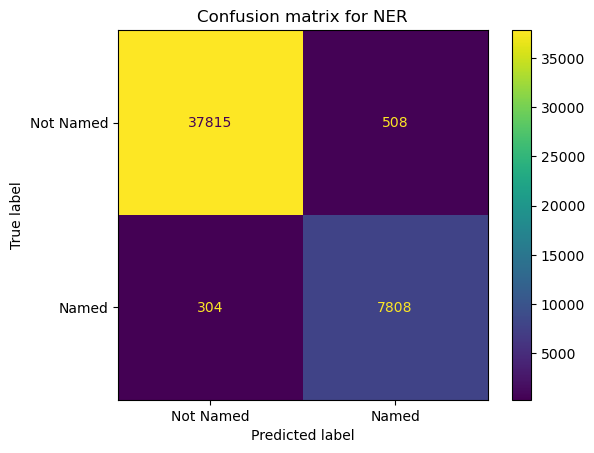

In [44]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred, labels = [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Named', 'Named'])
disp.plot()
plt.title('Confusion matrix for NER')
plt.show()

In [45]:
import nltk
from nltk.tokenize import word_tokenize 

# Load the model
pos_tagger = joblib.load('crf_pos_tagger.joblib')

# Convert tagged sentences into a list of (word, tag) pairs
def get_sentences_with_features(tagged_sentences):
    def word2features(sent, i):
        word = sent[i][0]
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
        }
        if i > 0:
            word1 = sent[i - 1][0]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.istitle()': word1.istitle(),
                '-1:word.isupper()': word1.isupper(),
            })
        else:
            features['BOS'] = True  # Beginning of Sentence

        if i < len(sent) - 1:
            word1 = sent[i + 1][0]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.istitle()': word1.istitle(),
                '+1:word.isupper()': word1.isupper(),
            })
        else:
            features['EOS'] = True  # End of Sentence

        return features

    return [
        ([word2features(sent, i) for i in range(len(sent))], [tag for word, tag in sent])
        for sent in tagged_sentences
    ]

def dummy_tag_tokenized_sentence(untagged_tokenized_sentence):
    result = []
    for word in untagged_tokenized_sentence:
        result.append((word, 'DUMMY'))
    return result

def predict_POS_Tags(sent):
    tokens = word_tokenize(sent)
    dummy_tag_sent = dummy_tag_tokenized_sentence(tokens)
    dummy_tag_sent_list = []
    dummy_tag_sent_list.append(dummy_tag_sent)
    feature_tensor = get_sentences_with_features(dummy_tag_sent_list)
    x_train = [sent[0] for sent in feature_tensor]
    predicted_tags = pos_tagger.predict(x_train)
    # return predicted_tags[0]
    output = []
    for i in range(len(predicted_tags[0])):
        output.append((tokens[i], predicted_tags[0][i]))
    return output
    

In [46]:
sample_sent = "Washington DC is the capital of United States of America"
print(predict_POS_Tags(sample_sent))
print(predict_POS_Tags(sample_sent)[1][1])
type(predict_POS_Tags(sample_sent)[1][1])

[('Washington', '22'), ('DC', '22'), ('is', '42'), ('the', '12'), ('capital', '21'), ('of', '15'), ('United', '22'), ('States', '22'), ('of', '15'), ('America', '22')]
22


str

In [47]:
# Feature extractor function: using the same one as for word2vec POS tagging
def word2features2(sent, i):
    word_list = sent.split()
    word = word_list[i]
    pos_tag = predict_POS_Tags(sent)[i][1]
    features = {
        'word.lower()': word.lower(),
        'is_upper': word.isupper(),
        'is_title': word.istitle(),
        'is_digit': word.isdigit(),
        'prefix-1': word[:1],
        'suffix-1': word[-1:],
        'prefix-2': word[:2],
        'suffix-2': word[-2:],
    }
    for tag_num, tag_name in reverse_pos_tags.items():
        features[f'pos_tag_{tag_name}'] = 1 if int(pos_tag) == tag_num else 0

    if i > 0:
        prev_word = word_list[i - 1]
        prev_pos_tag = predict_POS_Tags(sent)[i - 1][1]
        
        features.update({
            'prev_word.lower()': prev_word.lower(),
            'prev_is_upper': prev_word.isupper(),
            'prev_is_title': prev_word.istitle(),
            'prev_is_digit': prev_word.isdigit(),
            'prev_prefix-1': prev_word[:1],
            'prev_suffix-1': prev_word[-1:],
            'prev_prefix-2': prev_word[:2],
            'prev_suffix-2': prev_word[-2:]
        })
        for tag_num, tag_name in reverse_pos_tags.items():
            features[f'prev_pos_tag_{tag_name}'] = 1 if int(prev_pos_tag) == tag_num else 0
        
    
    else:
        # Special tokens for start of sentence
        features['BOS'] = True
   
    if i < len(word_list) - 1:
        next_word = word_list[i + 1]
        next_pos_tag = predict_POS_Tags(sent)[i + 1][1]
        features.update({
            'next_word.lower()': next_word.lower(),
            'next_is_upper': next_word.isupper(),
            'next_is_title': next_word.istitle(),
            'next_is_digit': next_word.isdigit(),
            'next_prefix-1': next_word[:1],
            'next_suffix-1': next_word[-1:],
            'next_prefix-2': next_word[:2],
            'next_suffix-2': next_word[-2:]
        })   
        for tag_num, tag_name in reverse_pos_tags.items():
            features[f'next_pos_tag_{tag_name}'] = 1 if int(next_pos_tag) == tag_num else 0 
    
    else:
        # Special token for the end of sentence
        features['EOS'] = True # End of Sentence
 
        
    return features

In [48]:
sent = "Washington DC is the capital of United States of America"
word2features2(sent, 1)

{'word.lower()': 'dc',
 'is_upper': True,
 'is_title': False,
 'is_digit': False,
 'prefix-1': 'D',
 'suffix-1': 'C',
 'prefix-2': 'DC',
 'suffix-2': 'DC',
 'pos_tag_"': 0,
 "pos_tag_''": 0,
 'pos_tag_#': 0,
 'pos_tag_$': 0,
 'pos_tag_(': 0,
 'pos_tag_)': 0,
 'pos_tag_,': 0,
 'pos_tag_.': 0,
 'pos_tag_:': 0,
 'pos_tag_``': 0,
 'pos_tag_CC': 0,
 'pos_tag_CD': 0,
 'pos_tag_DT': 0,
 'pos_tag_EX': 0,
 'pos_tag_FW': 0,
 'pos_tag_IN': 0,
 'pos_tag_JJ': 0,
 'pos_tag_JJR': 0,
 'pos_tag_JJS': 0,
 'pos_tag_LS': 0,
 'pos_tag_MD': 0,
 'pos_tag_NN': 0,
 'pos_tag_NNP': 1,
 'pos_tag_NNPS': 0,
 'pos_tag_NNS': 0,
 'pos_tag_NN|SYM': 0,
 'pos_tag_PDT': 0,
 'pos_tag_POS': 0,
 'pos_tag_PRP': 0,
 'pos_tag_PRP$': 0,
 'pos_tag_RB': 0,
 'pos_tag_RBR': 0,
 'pos_tag_RBS': 0,
 'pos_tag_RP': 0,
 'pos_tag_SYM': 0,
 'pos_tag_TO': 0,
 'pos_tag_UH': 0,
 'pos_tag_VB': 0,
 'pos_tag_VBD': 0,
 'pos_tag_VBG': 0,
 'pos_tag_VBN': 0,
 'pos_tag_VBP': 0,
 'pos_tag_VBZ': 0,
 'pos_tag_WDT': 0,
 'pos_tag_WP': 0,
 'pos_tag_WP$': 0,

In [49]:
for i, word in enumerate(sent.split()):
  print(f"Word: {word}, Entity: {svm_clf.predict(word2features2(sent, i))}")

Word: Washington, Entity: [1]
Word: DC, Entity: [1]
Word: is, Entity: [0]
Word: the, Entity: [0]
Word: capital, Entity: [0]
Word: of, Entity: [0]
Word: United, Entity: [1]
Word: States, Entity: [1]
Word: of, Entity: [0]
Word: America, Entity: [1]
